# Module 1.6: First Contact with the Data

> **Goal:** Run first-contact checks to confirm the data can support the 5Q Framework.

Each section maps to a 5Q question:

| Q | Name | What It Defines | First Contact Check |
|---|------|-----------------|---------------------|
| **Q1** | Decision | The Target | Is `y` clear, numeric, clean? |
| **Q2** | Metric | What "Good" Means | Issues that bias evaluation? (NAs, duplicates) |
| **Q3** | Horizon & Level | The Structure | Enough history? Right granularity? |
| **Q4** | Data & Drivers | What Model Learns | Behavioral signals (zeros, volatility) |

## 1. Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tsforge as tsf

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


## 2. Load Data

`messify=True` simulates real-world data issues (string dtypes, NaN injection, duplicates).

In [4]:
daily_sales = tsf.load_m5(
    DATA_DIR,
    messify=True,
    messify_kwargs={
        'random_state': 42,
        'zero_to_na_pct': 0.30,
        'add_duplicates': True,
        'n_duplicates': 150,
        'corrupt_dtypes': True,
        'drop_na_frac': 0.10,
        'cache_dir': DATA_DIR
    },
    include_hierarchy=True,
    verbose=True
)

LOADING M5 DATA
✓ M5 cache detected. Loading from local files...
✓ Loaded in 1.3s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.4 MB
  Columns: unique_id, ds, y
  Returning: Y_df, X_df, S_df (all 3 dataframes)

🔧 Applying messification...
LOADING CACHED MESSIFIED DATA

📁 Cache file: m5_messy_n30490_rs42_zna30_dup150_dtype1_rmv2_dropna10.parquet
   Using cached version (skip messification)

💡 To regenerate: set force_refresh=True

✓ Loaded 46,250,639 rows × 3 columns
  Expanding hierarchy via S_df merge...
  ✓ Added hierarchy columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

LOAD COMPLETE
  Shape: 46,250,639 rows × 7 columns
  Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y']
  Applied: messified, hierarchy columns


---

<div style="text-align: center;">

## 3. `Q1: Decision` — Defines the Target

<div style="background: linear-gradient(135deg, #2596be 0%, #3a2f7e 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Is the target clear, numeric, and clean?</strong><br>
</div>

</div>


### 3.1 Identify the Target

In [5]:
# What columns do we have?
daily_sales.columns

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y'], dtype='object')

### 3.2 Check Data Types

In [6]:
daily_sales[['ds', 'y']].dtypes

ds    object
y     object
dtype: object

### 3.3 Fix Data Type Issues

Messification corrupts dtypes. `errors='coerce'` converts unparseable values to proper NaN.

In [7]:
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])
daily_sales['y'] = pd.to_numeric(daily_sales['y'], errors='coerce')

In [8]:
daily_sales[['ds', 'y']].dtypes

ds    datetime64[ns]
y            float64
dtype: object

---

<div style="text-align: center;">

## 4. `Q2: Metric` — Defines What "Good" Means

<div style="background: linear-gradient(135deg, #1d1f56 0%, #2d42a7 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Are there issues that would bias our evaluation?</strong><br>
<em>Missingness, duplicates, and orphan data corrupt metrics.</em>
</div>

</div>


### 4.1 Check for Missing Values

In [9]:
daily_sales.isna().sum()

item_id           0
dept_id           0
cat_id            0
store_id          0
state_id          0
ds                0
y           7495875
dtype: int64

### 4.2 Handle Critical NAs

Drop rows with null dates (can't aggregate without a date). Target NAs handled in Module 1.10.

In [10]:
daily_sales = daily_sales.dropna(subset=['ds'])

### 4.3 Check for Null IDs

Rows with null ID columns are orphan data — they can't be aggregated properly.

In [11]:
id_cols = [c for c in daily_sales.columns if c not in ['ds', 'y']]
daily_sales[id_cols].isna().sum()

item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
dtype: int64

### 4.4 Check for Duplicates

Duplicates inflate aggregates and bias metrics. Remove before aggregating.

In [12]:
non_target_cols = [c for c in daily_sales.columns if c != 'y']
n_dups = daily_sales.duplicated(subset=non_target_cols)

In [13]:
n_dups.value_counts()

False    46250498
True          141
Name: count, dtype: int64

In [14]:
daily_sales = daily_sales.drop_duplicates(subset=non_target_cols)

---

<div style="text-align: center;">

## Q3: Horizon & Level — Defines the Structure
<div style="background: linear-gradient(135deg, #3a2f7e 0%, #2596be 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Do we have enough history at the right granularity?</strong><br>
</div>

</div>


### 5.1 Daily Data Summary

In [15]:
# inspect daily_sales before aggregating 
daily_sales.head(10)

,item_id,dept_id,cat_id,store_id,state_id,ds,y
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-29,3.0
1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-30,0.0
2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-31,0.0
3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-01,1.0
4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-02,4.0
5,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-03,2.0
6,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-04,NaN
7,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-05,2.0
8,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-06,0.0
9,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-07,0.0


### 5.2 Check Date Range

Rule of thumb: need 2-3x forecast horizon. For 12-week forecast, want ~36+ weeks.

In [16]:
# min date
daily_sales['ds'].min()

Timestamp('2011-01-29 00:00:00')

In [17]:
# max date
daily_sales['ds'].max()

Timestamp('2016-06-19 00:00:00')

In [18]:
# number of weeks
((daily_sales['ds'].max() - daily_sales['ds'].min()).days // 7) + 1

282

### 5.3 Check for Weird Dates

Look for dates before 1900, future dates, or outlier dates far from the main range.

In [19]:
unique_dates = (
    daily_sales['ds']
    .dropna()
    .drop_duplicates()
    .sort_values()
)

unique_dates.head(5), unique_dates.tail(5)

(0   2011-01-29
 1   2011-01-30
 2   2011-01-31
 3   2011-02-01
 4   2011-02-02
 Name: ds, dtype: datetime64[ns],
 1915   2016-06-15
 1916   2016-06-16
 1917   2016-06-17
 1918   2016-06-18
 1919   2016-06-19
 Name: ds, dtype: datetime64[ns])

### 5.4 Aggregate to Weekly

Weekly aligns with business planning (replenishment, labor, promos) and reduces daily noise.

In [20]:
# Group columns (everything except ds and y)
group_cols = [c for c in daily_sales.columns if c not in ['ds', 'y']]

In [21]:
# Create week column (W-SAT = weeks starting Sunday, ending Saturday)
daily_sales['week'] = daily_sales['ds'].dt.to_period('W-SAT').dt.start_time

In [22]:
# Aggregate: group by all id columns + week, sum the target
weekly_sales = (
    daily_sales.groupby(group_cols + ['week'], as_index=False, observed=True)
    ['y']
    .sum()
    .rename(columns={'week': 'ds'})
)

### 5.4 Daily vs Weekly Comparison

Compare the same series at daily vs weekly granularity.

In [23]:
# create a sample series by pulling the first unique series
first_series = daily_sales[group_cols].drop_duplicates().iloc[0]

# Filter data for this series
daily_mask = (daily_sales[group_cols] == first_series).all(axis=1)
weekly_mask = (weekly_sales[group_cols] == first_series).all(axis=1)


In [24]:
sample_daily = daily_sales[daily_mask].sort_values('ds')
sample_weekly = weekly_sales[weekly_mask].sort_values('ds')

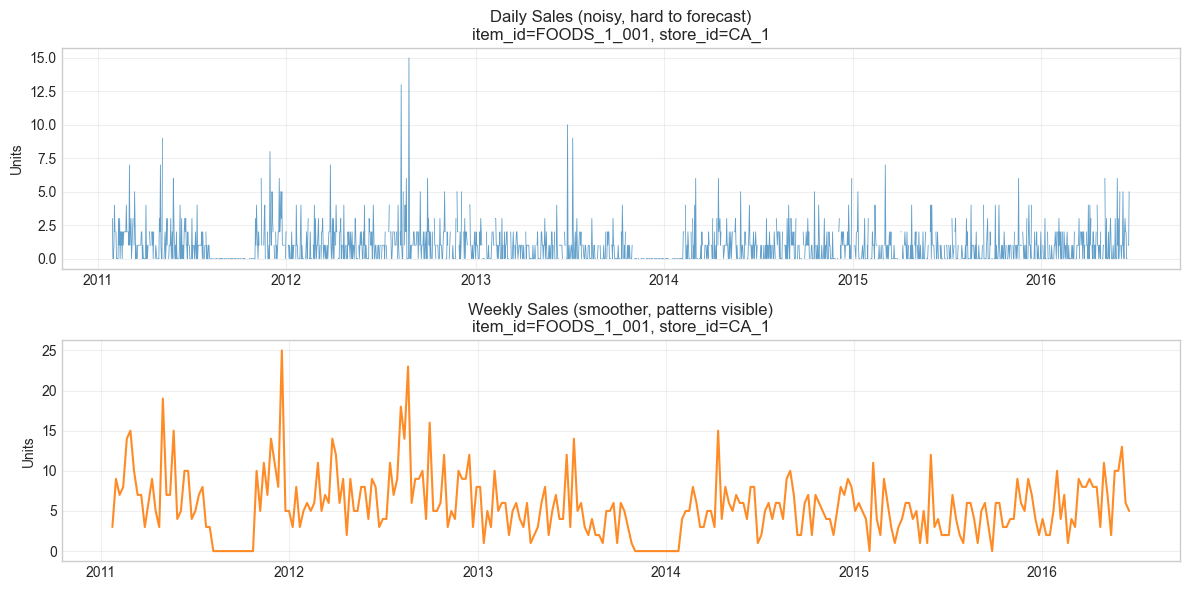

In [25]:
# Create label from series identifiers
label = f"item_id={first_series['item_id']}, store_id={first_series['store_id']}"

# Plot daily vs weekly
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(sample_daily['ds'], sample_daily['y'], alpha=0.7, linewidth=0.6)
axes[0].set_title(f'Daily Sales (noisy, hard to forecast)\n{label}')
axes[0].set_ylabel('Units')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample_weekly['ds'], sample_weekly['y'], alpha=0.9, linewidth=1.5, color='tab:orange')
axes[1].set_title(f'Weekly Sales (smoother, patterns visible)\n{label}')
axes[1].set_ylabel('Units')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

<div style="text-align: center;">

## 6. `Q4: Data` — Defines What the Model Learns

<div style="background: linear-gradient(135deg, #2d42a7 0%, #3a2f7e 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>What behavioral signals shape model selection?</strong><br>
<em>Intermittency, volatility, and data quality affect what the model can learn.</em>
</div>

</div>


### 6.1 Intermittency (Zeros)

High % zeros affects metric choice (MAPE undefined at 0) and model selection.

In [26]:
n_zeros = (weekly_sales['y'] == 0).sum()
n_na = weekly_sales['y'].isna().sum()

In [27]:
# percent of data with 0 sales
((n_zeros+n_na) / len(weekly_sales) * 100)

np.float64(24.019937906511053)

### 6.2 Data Summary

In [28]:
# before aggregating
daily_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 46250498 entries, 0 to 46250634
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   item_id   category      
 1   dept_id   category      
 2   cat_id    category      
 3   store_id  category      
 4   state_id  category      
 5   ds        datetime64[ns]
 6   y         float64       
 7   week      datetime64[ns]
dtypes: category(5), datetime64[ns](2), float64(1)
memory usage: 1.6 GB


In [29]:
# after aggregating
weekly_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848061 entries, 0 to 6848060
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   item_id   category      
 1   dept_id   category      
 2   cat_id    category      
 3   store_id  category      
 4   state_id  category      
 5   ds        datetime64[ns]
 6   y         float64       
dtypes: category(5), datetime64[ns](1), float64(1)
memory usage: 143.9 MB


---

## 7. First Contact Summary

Automated check across all 5Q dimensions:

In [ ]:
tsf.first_contact_check(weekly_sales)

FIRST CONTACT CHECK
✓ Required columns present (ds, y)
✓ ds is datetime
✓ y is numeric
✓ No NAs in ds
✓ No NAs in ID columns
ℹ 0 NAs in y (will impute in Module 1.10)
✓ No impossible dates
✓ No duplicates

Summary:
  Shape: 6,848,061 rows × 7 columns
  Series: 30,490
  Date range: 2011-01-23 to 2016-06-19
  Unique dates: 283
  Memory: 143.9 MB

✓ ALL CHECKS PASSED


True

## 8. Save Output

Save cleaned weekly data. NAs preserved for gap-filling in Module 1.10.

In [31]:
output_path = DATA_DIR / '1_6_output.parquet'
weekly_sales.to_parquet(output_path, index=False)

print(f"✓ Saved to {output_path}")

✓ Saved to data/1_6_output.parquet


## 9. Next Steps

| Module | Focus |
|--------|-------|
| **1.7** | Understand M5 structure (hierarchy, calendar, prices) |
| **1.8** | Diagnostics (seasonality, volatility, trend) |
| **1.9** | Portfolio analysis with GenAI |
| **1.10** | Data preparation (fill gaps, calendar merge, imputation) |
| **1.11** | Plotting & visual diagnostics |